# ML-Pipeline zur Clusteranalyse

Wir nutzen das in scikit-learn bereitgestellte Dataset ["20newsgroups"](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset) mit 18000 Newsgroups Beiträgen in 20 Kategorien zum Clustering von Textdaten. Ziel ist das Training eines Modells für die Gruppierung von Texten auf Basis der darin vorkommenden Wörter bzw einer Vektor-Repräsentation davon.

Die in diesem Notebook vorgestellte ML-Pipeline umfasst dabei:
* Vorverarbeitung der Daten
* Feature Engineering
* Training eines Clustering-Modells
* Evaluierung und Visualisierung der Ergebnisse

In [1]:
# Import und Initialisierung des KI-Assistenten bia-bob
from bia_bob import bob
# API Key wird aus condas Umgebungsvariable gelesen
bob.initialize(endpoint='blablador', model='alias-fast')

import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

## Datenvorverarbeitung und Feature Engineering

Ähnlich wie zur Datenvorverarbeitung im Notebook für die Klassifikation wollen wir auch beim Clustering vorgehen, mit einigen Anpassungen:
* Wir beschränken uns für einen besseren Überblick auf einen Teilbereich der Daten und Kategorien
* Beim Unsupervised Learning wie Clustering ist ein Train-Test-Split nicht notwendig

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'rec.sport.baseball',
    'comp.graphics',
    'sci.med',
]

# Laden der vorbereinigten Newsgroups Texte
ng_all_clean = fetch_20newsgroups(
    subset='test',
    categories=categories,
    remove=('headers', 'footers', 'quotes'))

# Entfernen unnötiger Zeilenumbrüche und Leerzeichen
ng_all_clean.data = [entry.strip() for entry in ng_all_clean.data]

X_text = ng_all_clean.data
y = ng_all_clean.target
unique_labels, category_sizes = np.unique(y, return_counts=True)
num_labels = unique_labels.shape[0]
print(f"{len(X_text)} Texte - {num_labels} Kategorien")

target_names = ng_all_clean.target_names
pprint(list(enumerate(ng_all_clean.target_names)))

1182 Texte - 3 Kategorien
[(0, 'comp.graphics'), (1, 'rec.sport.baseball'), (2, 'sci.med')]


Wir definieren eine [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) zum Feature Engineering:
* Schritt 1: TF-IDF Vektoren für die Texte
* Schritt 2: TF-IDF Vektoren mittels _Singular Value Decomposition (SVD)_ zu 100-dimensionalen Vektoren transformieren (ähnlich LSA)
* Schritt 3: SVD Vektoren normalisieren

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

vec_pipe = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    TruncatedSVD(n_components=100, random_state=42),
    Normalizer(copy=False)
)

## Training und Evaluierung

Wir definieren eine Funktion zur Evaluierung und Visualisierung der Clustering-Ergebnisse.  

Wir nutzen die folgenden Cluster-Metriken:
* [Homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html): Gibt an, wie viele Cluster nur Mitglieder einer einzigen Klasse enthalten (Wert zw. 0.0 and 1.0, größer ist besser)
* [Completeness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html): Gibt an, wie viele Mitglieder einer bestimmten Klasse denselben Clustern zugeordnet sind (Wert zw. 0.0 and 1.0, größer ist besser)
* V-Measure: Das harmonische Mittel aus Completeness und Homogeneity
* [Silhouette](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html): Der beste Wert ist 1,  der schlechteste Wert ist -1. Werte nahe 0 deuten auf sich überschneidende Cluster hin. Negative Werte weisen darauf hin, dass Samples einem falschen Cluster zugeordnet wurden, und einem anderen Cluster ähnlicher sind.

Für die Visualisierung müssen die hochdimensionalen TF-IDF/SVD Vektoren mittels Dimensionreduktion in einen 2-Dimensionalen Raum transformiert werden. Hier bietet sich wieder die _Singular Value Decomposition (SVD)_ an: [`TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score

def evaluate_visualize(pipe):
    # Cluster-Label vorhersagen
    predictions = pipe.fit_predict(X_text)
    # Text-Vektoren aus Pipeline erhalten
    X_vec = pipe[:-1].transform(X_text)
    
    print(f'Evaluierung für {pipe['clu'].__class__.__name__}')
    h,c,v = homogeneity_completeness_v_measure(y, predictions)
    s = silhouette_score(X_vec, predictions)
    print('Homogeneity Score: ', h)
    print('Completeness Score: ', c)
    print('V-Measure Score: ', v)
    print('Silhouette Score: ', s)
    
    # Weitere Dimensionreduktion für 2D
    svd2 = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd2.fit_transform(X_vec)

    df_plot = pd.DataFrame({
        'x': X_2d[:, 0],
        'y': X_2d[:, 1],
        "true_label": [(i, target_names[i]) for i in y],
        "pred_label": predictions
    })
    
    # Farbpalette
    palette = sns.color_palette("tab10", n_colors=len(target_names))
    # Scatterplot mit Seaborn
    plt.figure(figsize=(8, 8))
    sns.scatterplot(data=df_plot, x='x', y='y',
                    hue='true_label',  
                    style="pred_label",
                    palette=palette,
                    s=30, edgecolor="black", linewidth=0.5
                   )
    plt.title(f'Cluster-Visualisierung für {pipe['clu'].__class__.__name__}')
    plt.xlabel("SVD-1")
    plt.ylabel("SVD-2")
    plt.tight_layout()
    plt.show()
    

### k-Means Clustering

Evaluierung für KMeans
Homogeneity Score:  0.5615509676459444
Completeness Score:  0.5690854030400372
V-Measure Score:  0.5652930810220175
Silhouette Score:  0.023676790375802486


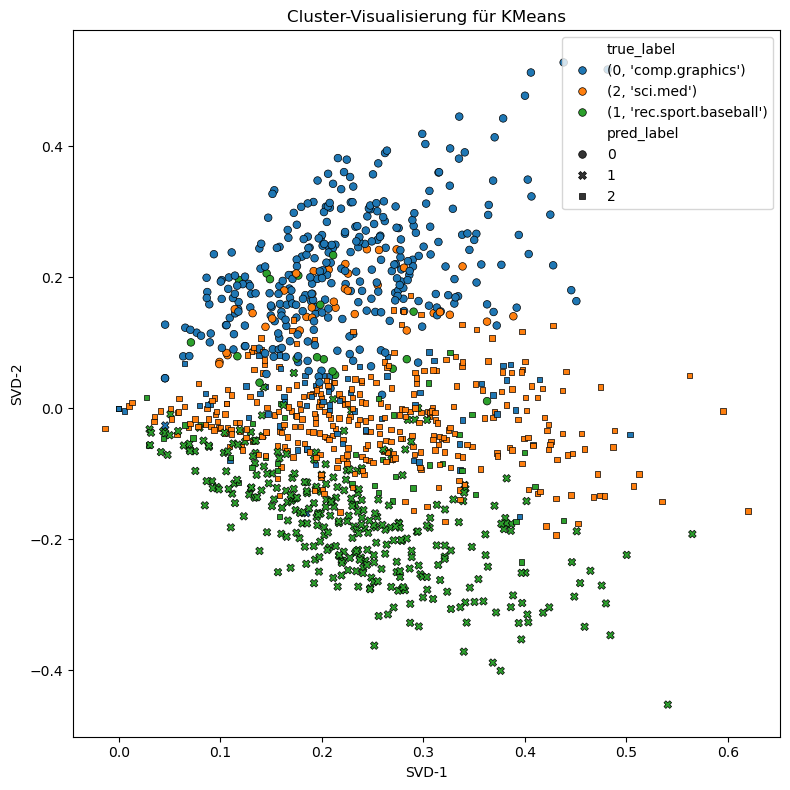

In [5]:
from sklearn.cluster import KMeans

kmeans_pipe = Pipeline([
    ('vec', vec_pipe),
    ('clu', KMeans(
        n_clusters=num_labels,
        max_iter=500,
        n_init=10,
        random_state=42
    ))
])

evaluate_visualize(kmeans_pipe)